# Goal
1. Analyze customers' annual spending
2. Decide whether to introduce a loyalty program that incentivizes customers to purchase across multiple offering categories
3. Attract the largest subgroup of customers

Keyword: across categories, largest subgroup of customers

# Key Findings and Business Insights
1. The behavior of customers are studied by their consumption correlation across categories. Principal component analysis and K-means are applied for customer segmentation. 
2. Multiple loyalty programs are proposed under different scenario.
3. The royalty program should be revisited some time after the program introduced, in order to examine the effect of the program. (or try a smaller scale program experiment on targeted customers first before launching the full-scale program.)
4. For future data collection, it is good to have more frequent data. If the quarterly or monthly data is available, seasonality can be studied and it is possible to introduce the loyalty program on rotating categories.
 
 
## Proposed Loyalty Programs
Three loyalty programs are proposed for different use case.
### Channel-Based Program (See Sec. 2.3)
#### - It is eady to segment the customers from different channels.
#### - The most distinguishable interaction effects between two channels are "Milk * detergent_paper" and "Grocery * detergent_paper". 
#### - Proposed offering for channel 2 customer: discount for purchasing "milk and detergent paper" or "grocery and detergent paper".
#### - Proposed offering for channel 1 customer: discount on "fresh and frozen"
#### - Alternative offering for channel 2 customer: discount on detergent paper plus any other category. It is a broader loyalty program and offers more freedom for channel 2 customers.


### Purchasing-Based Program (See Sec. 2.2)
#### - It works even when the customer's channel is unknown.
#### - It is applicable when customers are acquired from new channels.
#### - Offer the following royalty program scheme for customers to choose from:
##### 1. Discount for consumption across any multiple categories. (for capturing the customers with no clear spending preference)
##### 2. Special discount for customers who buy "Milk", "Grocery", and "Detergents_Paper" over a certain amount.
##### 3. Special discount for customers who buy "Fresh", "Delicanssen" over a certain amount.

### One-for-All Program (See Sec. 2.1)
#### - The program is based on the highest cross-category spendings. 
#### - Easy to implement, and cover all customers
#### - Discount for purchase across "Milk, Grocery, and Detergents_Paper" and across "Grocery and Detergents_Paper".

# Data

The data is annual spending of the customers from the last 2 years, which includes the following features:

- Customer: customer ID
- YEAR: year
- FRESH: annual spending on fresh products
- DAIRY: annual spending on dairy products
- GROCERY: annual spending on grocery products
- FROZEN: annual spending on frozen products
- DETERGENTS_PAPER: annual spending on detergents and paper products
- DELI: annual spending on delicatessan products
- CHANNEL: HoRECA (hotel/restaurant) or RETAIL

(but the CANNEL is labeled as 1 and 2. It's not clear what number represents which channel.)

# 1. Data Cleaning

In [71]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import time
import seaborn as sns
import sklearn
from math import sqrt
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings("ignore") 

In [3]:
df = pd.read_csv("wholesale_data.csv")
df.head()

,Channel,Customer,Year,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,6048141,2017,12669,9656,7561,214,2674,1338
1,2,9336325,2017,7057,9810,9568,1762,3293,1776
2,2,6272942,2017,6353,8808,7684,2405,3516,7844
3,1,7856217,2017,13265,1196,4221,6404,507,1788
4,2,6179511,2017,22615,5410,7198,3915,1777,5185


### All the features should be numbers, but they are not. There might be missing data.

In [8]:
df.dtypes

Channel              int64
Customer             int64
Year                object
Fresh               object
Milk                object
Grocery             object
Frozen              object
Detergents_Paper    object
Delicassen          object
dtype: object

Check the number of non-number data in each column. Find "Year" column has many non-number data.

In [4]:
column_names = df.columns
num_true_strings = np.zeros(df.shape[1])
unique_strings = []
for i in range(column_names.shape[0]):
    true_strings = pd.to_numeric(df[column_names[i]], errors='coerce').isnull()
    num_true_strings[i] = df.loc[true_strings,column_names[i]].count()
    unique_strings.append(df.loc[true_strings,column_names[i]].unique())
print('The number of true strings for each column are')
num_true_strings

The number of true strings for each column are


array([  0.,   0., 361.,   2.,   3.,   1.,   5.,   1.,   2.])

In [5]:
df['Year']

0            2017
1            2017
2            2017
3            2017
4            2017
5            2017
6            2017
7            2017
8            2017
9            2017
10           2017
11           2017
12           2017
13           2017
14           2017
15           2017
16           2017
17           2017
18           2017
19           2017
20           2017
21           2017
22           2017
23           2017
24           2017
25           2017
26           2017
27           2017
28           2017
29           2017
          ...    
771    08/01/2016
772    08/01/2016
773    08/01/2016
774    08/01/2016
775    08/01/2016
776    08/01/2016
777    08/01/2016
778    08/01/2016
779    08/01/2016
780    08/01/2016
781    08/01/2016
782    08/01/2016
783    08/01/2016
784    08/01/2016
785    08/01/2016
786    08/01/2016
787    08/01/2016
788    08/01/2016
789    08/01/2016
790    08/01/2016
791    08/01/2016
792    08/01/2016
793    08/01/2016
794    08/01/2016
795    08/

Check non-number data

In [6]:
print('The unique strings for each column are')
unique_strings

The unique strings for each column are


[array([], dtype=int64),
 array([], dtype=int64),
 array(['08/01/2016'], dtype=object),
 array(['unrecorded', nan], dtype=object),
 array([nan, 'unrecorded'], dtype=object),
 array([nan, 'unrecorded'], dtype=object),
 array(['unrecorded', nan], dtype=object),
 array(['unrecorded', nan], dtype=object),
 array(['unrecorded', nan], dtype=object)]

There is just one date in 2016, so convert it as '2016'.

In [7]:
for i in range(len(df)):
    if df.Year[i] == '08/01/2016':
        df.Year[i] = 2016

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


There are not many missing data (compared with sample size), so drop all missing data.

In [8]:
df = df[df['Fresh'] != 'unrecorded']
df = df[df['Milk'] != 'unrecorded']
df = df[df['Grocery'] != 'unrecorded']
df = df[df['Frozen'] != 'unrecorded']
df = df[df['Detergents_Paper'] != 'unrecorded']
df = df[df['Delicassen'] != 'unrecorded']

In [9]:
df.dropna(axis=0, how='any', inplace=True)

Make sure there is no "string" datatype anymore.

In [10]:
column_names = df.columns
num_true_strings = np.zeros(df.shape[1])
unique_strings = []
for i in range(column_names.shape[0]):
    true_strings = pd.to_numeric(df[column_names[i]], errors='coerce').isnull()
    num_true_strings[i] = df.loc[true_strings,column_names[i]].count()
    unique_strings.append(df.loc[true_strings,column_names[i]].unique())
print('The number of true strings for each column are')
num_true_strings

The number of true strings for each column are


array([0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [11]:
print('The unique strings for each column are')
unique_strings

The unique strings for each column are


[array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=object),
 array([], dtype=object),
 array([], dtype=object),
 array([], dtype=object),
 array([], dtype=object),
 array([], dtype=object),
 array([], dtype=object)]

convert all the data to numeric datatype

In [14]:
features = ['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen']
for col in features:
    df[col] = pd.to_numeric(df[col])
df.Year = pd.to_numeric(df.Year)

In [15]:
df.shape

(770, 9)

Check if there are duplicated data, and found many.

In [16]:
sum(df.duplicated(['Customer']))

296

In [69]:
df_repeat = df[df.duplicated(['Customer'], keep=False)]

In [70]:
df_repeat.head(30)

,Channel,Customer,Year,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,6048141,2017,12669,9656,7561,214,2674,1338
2,2,6272942,2017,6353,8808,7684,2405,3516,7844
3,1,7856217,2017,13265,1196,4221,6404,507,1788
4,2,6179511,2017,22615,5410,7198,3915,1777,5185
5,2,2288780,2017,9413,8259,5126,666,1795,1451
6,2,4005184,2017,12126,3199,6975,480,3140,545
7,2,5508432,2017,7579,4956,9426,1669,3321,2566
8,1,7407238,2017,5963,3648,6192,425,1716,750
9,2,8386256,2017,6006,11093,18881,1159,7425,2098
10,2,4538271,2017,3366,5403,12974,4400,5977,1744


Figure out those duplicated data are actually repeat customers.
Repeat customers might be a good target for the loyalty program, but according to the count, they are not the largest subgroup. 

In [73]:
df_repeat[df_repeat['Customer']==3182887]

,Channel,Customer,Year,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
33,1,3182887,2017,29729,4786,7326,6130,361,1083
473,1,3182887,2016,30324,4307,6374,5640,321,942


Try to find if there are outliers.

In [99]:
df.describe()

,Channel,Customer,Year,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,770.000000,7.700000e+02,770.000000,770.000000,770.000000,770.000000,770.000000,770.000000,770.000000
mean,1.346753,5.329454e+06,2016.541558,11025.228571,5212.823377,7258.512987,2677.551948,2733.454545,1352.505195
std,0.476246,2.532678e+06,0.498594,12028.376337,6793.939235,8901.713899,4324.496290,4518.502233,2662.518330
min,1.000000,1.133724e+06,2016.000000,2.000000,52.000000,2.000000,25.000000,2.000000,2.000000
25%,1.000000,3.287590e+06,2016.000000,2794.000000,1367.500000,2000.750000,603.000000,236.250000,372.000000
50%,1.000000,5.250036e+06,2017.000000,7412.500000,3217.000000,4422.500000,1292.500000,760.000000,834.000000
75%,2.000000,7.303826e+06,2017.000000,15174.750000,6464.250000,9484.500000,3038.500000,3598.250000,1602.500000
max,2.000000,9.990301e+06,2017.000000,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


I checked each column and some possible numbers, and found they could not be treated as outlier, because there are still some customers purchasing with extereme values. 

In [126]:
df[df['Fresh']>50000]

,Channel,Customer,Year,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
39,1,8944950,2017,56159,555,902,10002,212,2916
103,1,7486118,2017,56082,3504,8906,18028,1480,2498
125,1,9732315,2017,76237,3473,7102,16538,778,918
181,1,9467696,2017,112151,29627,18148,16745,4948,8550
259,1,2761399,2017,53205,4959,7336,3012,967,818
284,1,3558780,2017,68951,4411,12609,8692,751,2406
479,1,8944950,2016,56159,322,532,6501,172,2508
565,1,9732315,2016,56415,2501,4048,11577,692,771
621,1,9467696,2016,89721,19554,14155,12224,4453,6926
698,1,4180398,2016,52157,3148,1912,3339,657,1959


# 2. Analyze Consumer Behavior
1. Count customers from different channel, in order to find whether to target different customers.
2. Analyze the correlation across different categories, because the planned program are incentive for purchasing across multiple offering categories.
3. Found there are more custemors from channel 1 than from channel 2. 

In [11]:
df[df['Channel']==1].count()

Channel             503
Customer            503
Year                503
Fresh               503
Milk                503
Grocery             503
Frozen              503
Detergents_Paper    503
Delicassen          503
dtype: int64

### Overall, the correlation between "Milk", "Grocery", and "Detergents_Paper" are the highest, and also correlation between "Grocery" and "Detergents_Paper".
### The behaviors of customers from channel 1 and 2 are different. 

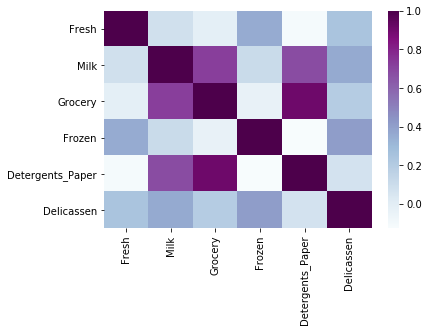

In [94]:
ax = sns.heatmap(df.iloc[:,3:].corr(), cmap="BuPu")

### For customers from channel 1, the correlation between "Milk", "Grocery", and "Delicassen" are the highest. Also observe correlation between "Grocery" and "Detergents_Paper".

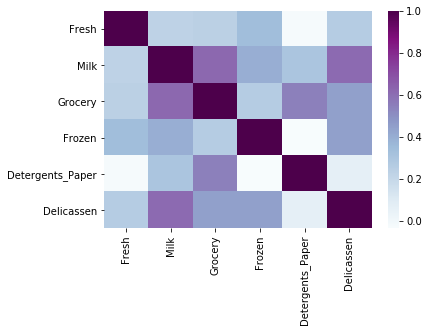

In [96]:
ax1 = sns.heatmap(df[df['Channel']==1].iloc[:,3:].corr(), cmap="BuPu")

### For customers from channel 2, the correlation between "Milk", "Grocery", and "Detergents_Paper" are the highest. Also observe correlation between "Grocery" and "Detergents_Paper". The pattern is similar with overall correlation, but less correlation in "Fresh" and "Delicassen"

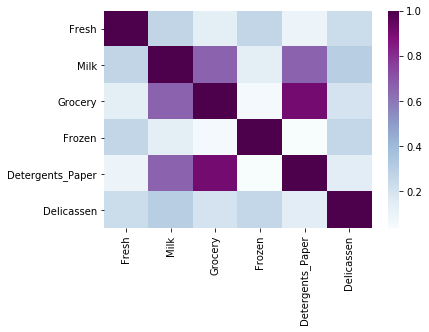

In [98]:
ax1 = sns.heatmap(df[df['Channel']==2].iloc[:,3:].corr(), cmap="BuPu")

## 2.1 Use Principal Component Analysis to Find Customer Clusters

scale the data before PCA

In [28]:
df_scaled = df.copy()

for col in features:
    df_scaled[col] = [(y - df[col].mean()) / df[col].std() for y in df[col]]


In [29]:
df_scaled.describe()

,Channel,Customer,Year,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,770.000000,7.700000e+02,770.000000,7.700000e+02,7.700000e+02,7.700000e+02,7.700000e+02,7.700000e+02,7.700000e+02
mean,1.346753,5.329454e+06,2016.541558,3.085555e-17,2.379049e-17,5.104142e-17,5.853903e-17,-1.117432e-16,3.662294e-17
std,0.476246,2.532678e+06,0.498594,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,1.000000,1.133724e+06,2016.000000,-9.164353e-01,-7.596217e-01,-8.151816e-01,-6.133782e-01,-6.045044e-01,-5.072285e-01
25%,1.000000,3.287590e+06,2016.000000,-6.843175e-01,-5.659932e-01,-5.906461e-01,-4.797211e-01,-5.526620e-01,-3.682623e-01
50%,1.000000,5.250036e+06,2017.000000,-3.003505e-01,-2.937653e-01,-3.185918e-01,-3.202805e-01,-4.367497e-01,-1.947424e-01
75%,2.000000,7.303826e+06,2017.000000,3.449777e-01,1.841975e-01,2.500627e-01,8.346592e-02,1.913898e-01,9.389412e-02
max,2.000000,9.990301e+06,2017.000000,8.407267e+00,1.005090e+01,9.607306e+00,1.345624e+01,8.430569e+00,1.749866e+01


In [30]:

pca = PCA(n_components=6)
principalComponents = pca.fit_transform(df_scaled.iloc[:,3:])
principalDf = pd.DataFrame(data = principalComponents)
df_PCA = pd.concat([df_scaled.iloc[:,:3],principalDf], axis = 1)
print(pca.explained_variance_ratio_)
pca.components_

[0.43880654 0.28644076 0.12286085 0.08982255 0.0491264  0.01294289]


array([[ 0.03541239,  0.5462199 ,  0.57872602,  0.0520931 ,  0.55516474,
         0.23354742],
       [ 0.52868488,  0.0641237 , -0.12839453,  0.61728636, -0.2365838 ,
         0.51271917],
       [-0.80987317,  0.03983501, -0.10396305,  0.17778247, -0.12063926,
         0.53436866],
       [-0.24401653, -0.06732343,  0.09457691,  0.76379678,  0.14993043,
        -0.56666925],
       [-0.04480796,  0.83150445, -0.36069639, -0.02840797, -0.32547783,
        -0.26409823],
       [-0.04233068,  0.00361184,  0.70621246, -0.0210883 , -0.70203379,
        -0.07850398]])

### The first 2 components combined explained 72% of variance. The first component has high weights in “Milk”, "Grocery", and "Detergents_Paper", which is consistent with the previous finding in correlation.

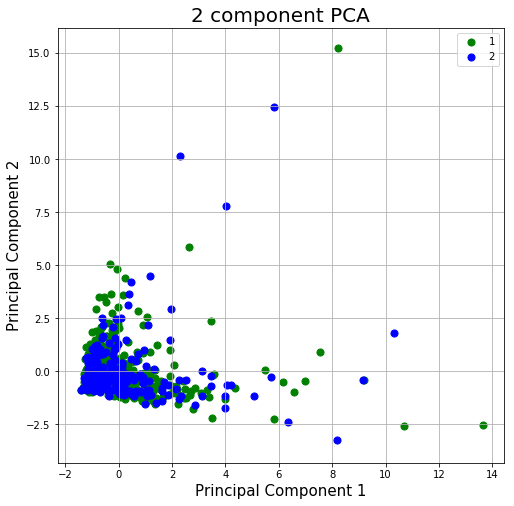

In [148]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = [1,2]
colors = ['g', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = df_PCA['Channel'] == target
    ax.scatter(df_PCA.loc[indicesToKeep, 0]
               , df_PCA.loc[indicesToKeep, 1]
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

### PCA actually couldn't distinguish customers from different channels.

### Next, I'd like to examine whether the consumption in the two years are different. 

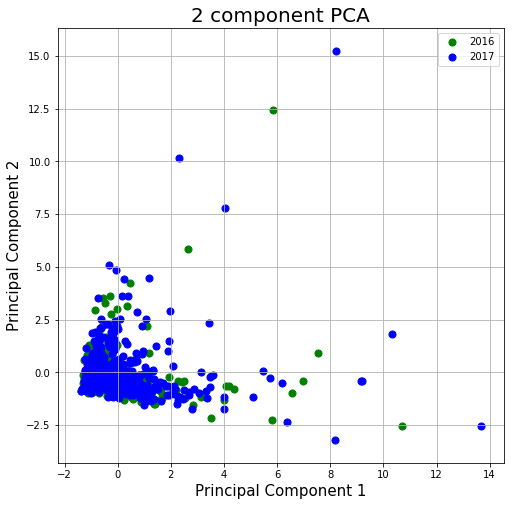

In [152]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = [2016,2017]
colors = ['g', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = df_PCA['Year'] == target
    ax.scatter(df_PCA.loc[indicesToKeep, 0]
               , df_PCA.loc[indicesToKeep, 1]
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

### Not much differece between 2016 and 2017.

## 2.2 Customer Cluster by K-Means

In [48]:
from sklearn.cluster import KMeans

# Number of clusters
kmeans = KMeans(n_clusters=4, n_jobs=-1)
# Fitting the input data
kmeans_res = kmeans.fit(df_scaled[features])
# Getting the cluster labels
labels = kmeans_res.predict(df_scaled[features])
# Centroid values
centroids = kmeans_res.cluster_centers_

In [50]:
df_kmeans = pd.concat([df_PCA,pd.DataFrame(data=labels, columns=['Cluster'])], axis = 1)

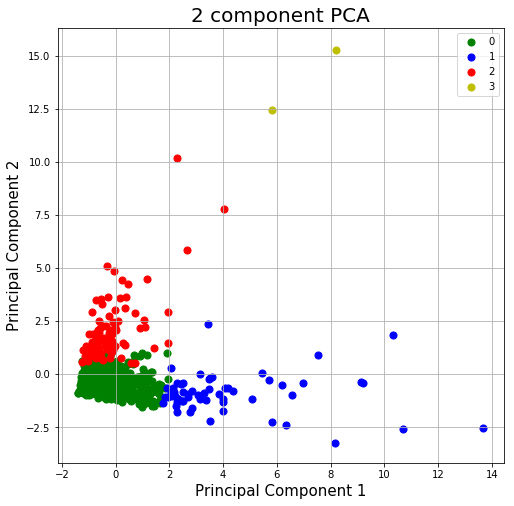

In [52]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = [0,1,2,3]
colors = ['g', 'b', 'r', 'y']
for target, color in zip(targets,colors):
    indicesToKeep = df_kmeans['Cluster'] == target
    ax.scatter(df_kmeans.loc[indicesToKeep, 0]
               , df_kmeans.loc[indicesToKeep, 1]
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

 #### K-means is able to segment the customers as 3 clusters. (plus the 4th group as the outlier, they buy extremely more than the others.) The three clusters are:
 #### Cluster 0: Small Buyers, they spend less, and they don't have clear purchasing preference.
 #### Cluster 1: People who buy more "Milk", "Grocery", and "Detergents_Paper"
 #### Cluster 2: People who buy more "Fresh", "Delicanssen"
 
 #### According to the clusters, I propose the following loyalty programs schemes for customers to choose from. 
 #### 1. Discount for consumption across any multiple categories.
 #### 2. Special discount for customers who buy "Milk", "Grocery", and "Detergents_Paper" over a certain amount.
 #### 3. Special discount for customers who buy "Fresh", "Delicanssen" over a certain amount.
The customers will choose the most suitable discount scheme according to their spending behavior, so the customers are segmented automatically. Therefore, we don't have to know their channels. It is an advantage if we have missing data for channels, or when we have new customers that we don't know their channel. Moreover, all the customers are covered in the discount scheme. If we want to focus only on subgroup of customers, we can only offer Discount 2. and 3. In this case, we are able to retain the customers with the highest consumption power. In addition, the small buyer are offered the incentive to purchase more.

## 2.3 Study the Interaction Effect between Categories by Feature Engineering
The company is interested particularly in cross category loyalty program, so I examine the interaction effects across categories.

In [54]:
df2 = df.copy()
for i in range(3, len(list(df))):
    for j in range(i+1,len(list(df))):
        df2[list(df)[i]+'*'+list(df)[j]] = 0
        df2[list(df)[i]+'*'+list(df)[j]] = df.apply(lambda x: sqrt(float(x[[i]])*float(x[[j]])), axis=1)

In [57]:
df2 = df2.drop(labels = features, axis='columns')

In [58]:
df2.head(5)

,Channel,Customer,Year,Fresh*Milk,Fresh*Grocery,Fresh*Frozen,Fresh*Detergents_Paper,Fresh*Delicassen,Milk*Grocery,Milk*Frozen,Milk*Detergents_Paper,Milk*Delicassen,Grocery*Frozen,Grocery*Detergents_Paper,Grocery*Delicassen,Frozen*Detergents_Paper,Frozen*Delicassen,Detergents_Paper*Delicassen
0,2,6048141,2017,11060.373592,9787.252372,1646.561873,5820.387101,4117.174031,8544.531351,1437.492261,5081.352576,3594.402315,1272.027515,4496.455715,3180.663138,756.462821,535.099991,1891.510508
1,2,9336325,2017,8320.406841,8217.139162,3526.249282,4820.653586,3540.230501,9688.244423,4157.549759,5683.689823,4174.034020,4105.948855,5613.147424,4122.228524,2408.789322,1768.986150,2418.339926
2,2,6272942,2017,7480.456136,6986.877128,3908.831667,4726.219208,7059.244435,8226.826363,4602.525394,5564.973315,8312.036574,4298.839378,5197.782604,7763.587830,2907.916780,4343.365055,5251.619179
3,1,7856217,2017,3983.081721,7482.751165,9216.781434,2593.328942,4870.094455,2246.845789,2767.523080,778.698915,1462.343325,5199.161856,1462.889948,2747.207309,1801.895668,3383.836876,952.111338
4,2,6179511,2017,11061.064596,12758.635115,9409.448709,6339.310294,10828.609098,6240.286852,4602.189696,3100.575753,5296.305316,5308.499788,3576.429225,6109.143148,2637.604026,4505.471673,3035.415128


### Visualize the distribution of customers from two channels, in order to see whether there are different.

In [64]:
# make general plots to examine each feature
def plot_var(df, col_name, full_name, group_col, continuous):
    """
    Visualize a variable with/without facet.
    - col_name is the variable name in the dataframe
    - full_name is the full variable name
    - continuous is True for continuous variables
    
    """
    
    fig, (ax1, ax2) = plt.subplots(1, 2, sharex=False, figsize=(15,3))
    # plot1: counts distribution of the variable    
    if continuous:  
        sns.distplot(df.loc[df[col_name].notnull(), col_name], kde=False, ax=ax1)
    else:
        sns.countplot(df[col_name], order=sorted(df[col_name].unique()), color='#5975A4', saturation=1, ax=ax1)
    ax1.set_xlabel(full_name)
    ax1.set_ylabel(group_col)
    ax1.set_title(full_name)

          
    # plot2: bar plot of the variable grouped by group_col
    if continuous:
        sns.boxplot(x=group_col, y=col_name, data=df, ax=ax2)
        ax2.set_ylabel('')
        ax2.set_title(full_name + ' by ' + group_col)
    else:
        Charged_Off_rates = df.groupby(col_name)[group_col].value_counts(normalize=True)[:,1]
        sns.barplot(x=Charged_Off_rates.index, y=Charged_Off_rates.values, color='#5975A4', saturation=1, ax=ax2)
#        ax2.set_ylabel('Fraction of Loans Charged Off')
#        ax2.set_title('Charged Off Rate by ' + full_name)
        ax2.set_xlabel(full_name)
    
    # plot3: kde plot of the variable gropued by group_col
    if continuous:  
        facet = sns.FacetGrid(df, hue = group_col, size=3, aspect=4)
        facet.map(sns.kdeplot, col_name, shade=True)
        #facet.set(xlim=(df[col_name].min(), df[col_name].max()))
        facet.add_legend()  
    else:
        fig = plt.figure(figsize=(12,3))
        sns.countplot(x=col_name, hue=group_col, data=df, order=sorted(df[col_name].unique()))
     
    plt.tight_layout()

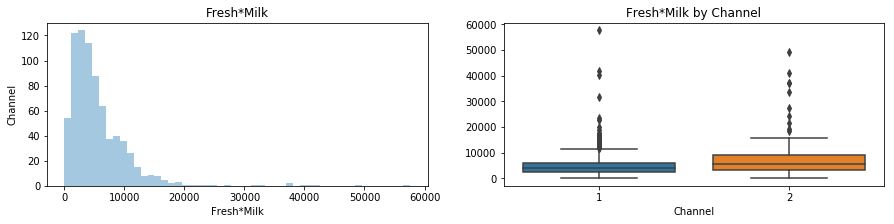

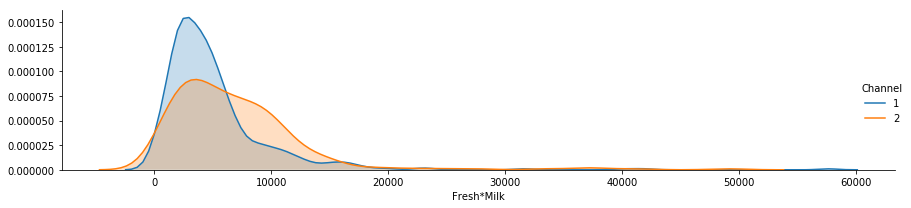

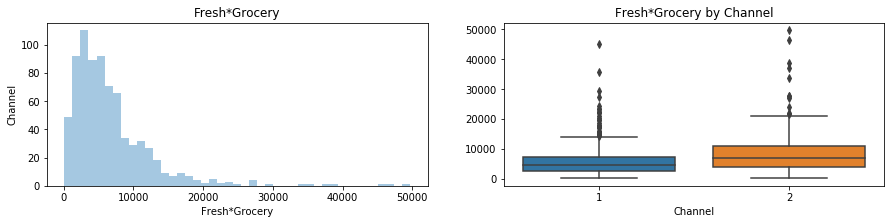

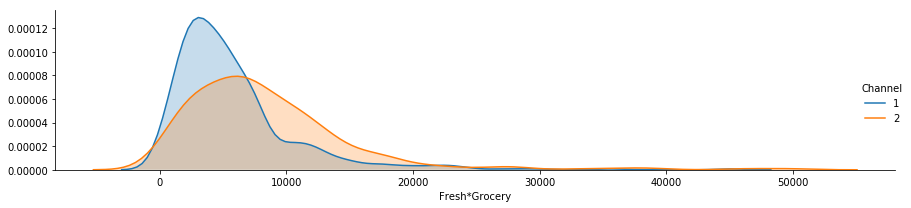

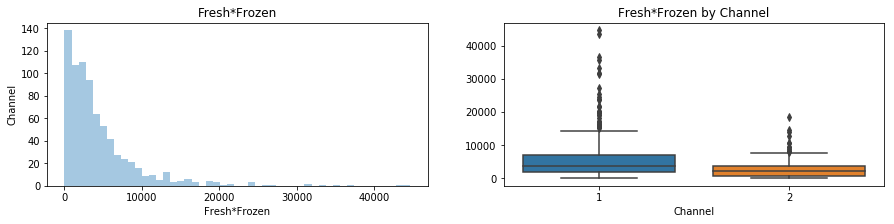

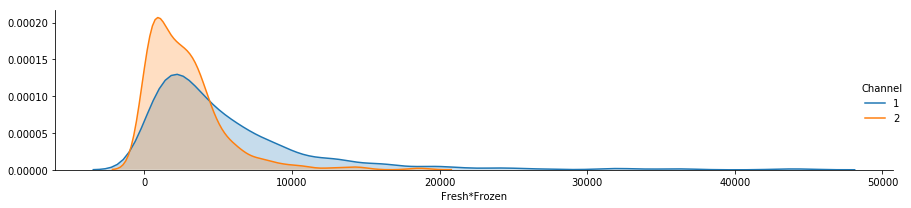

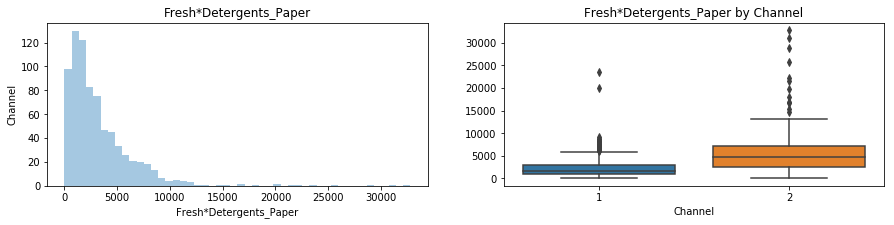

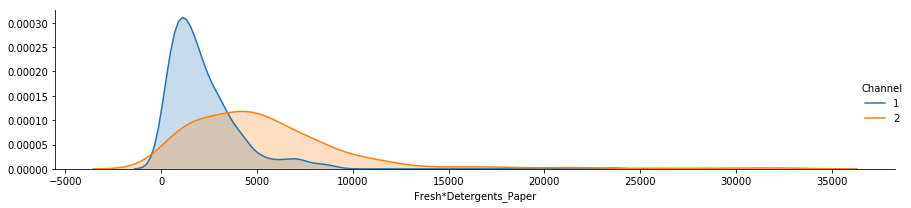

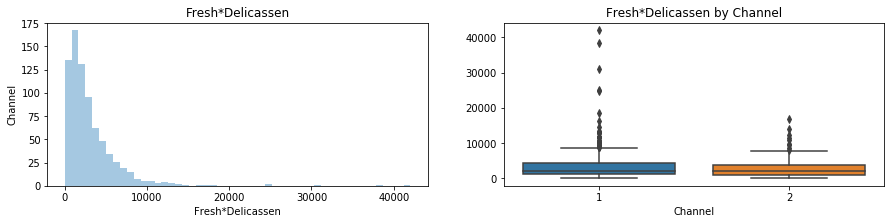

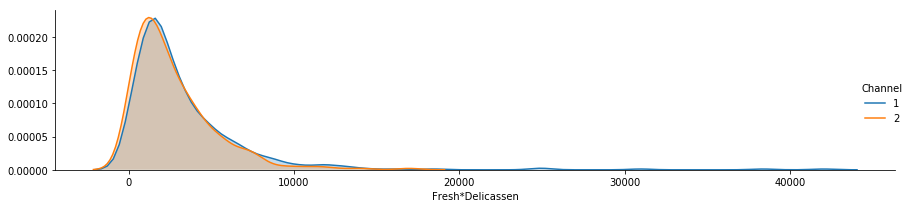

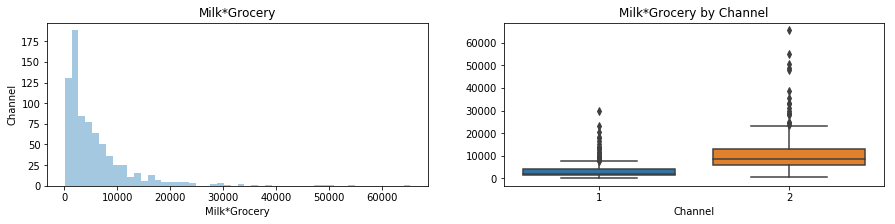

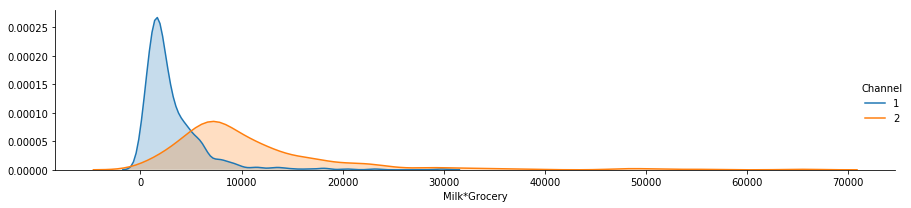

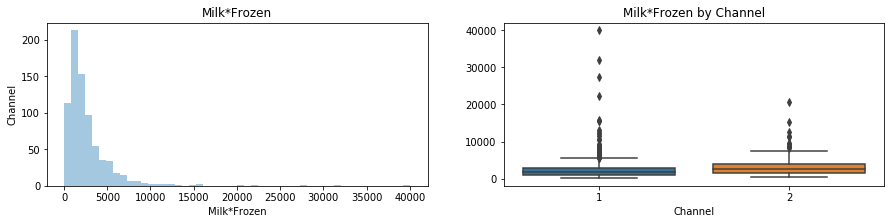

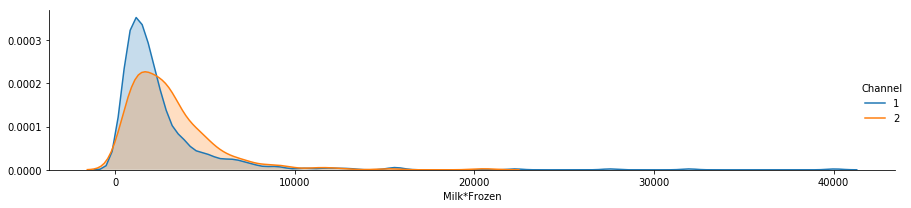

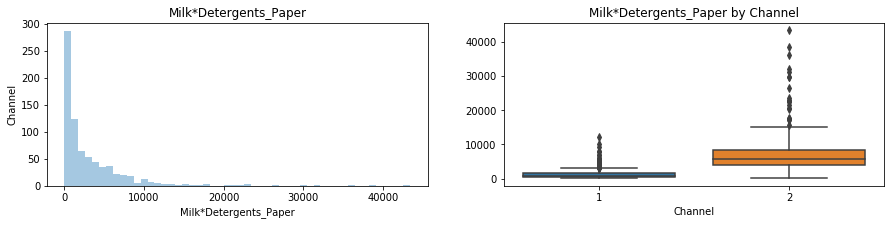

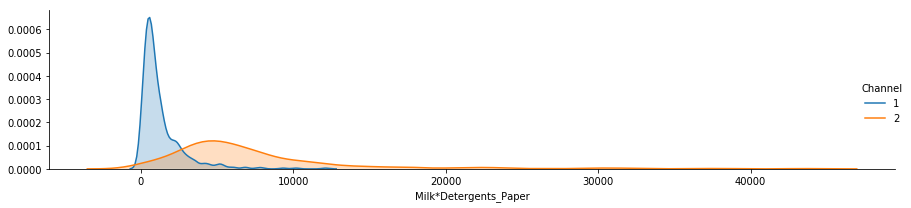

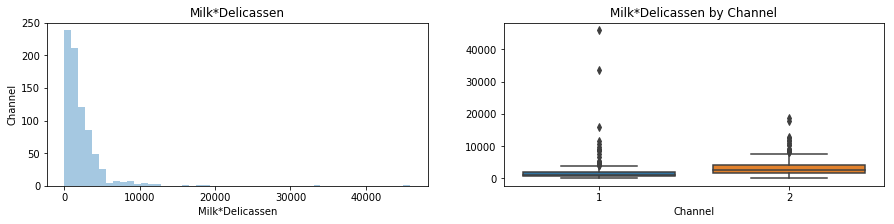

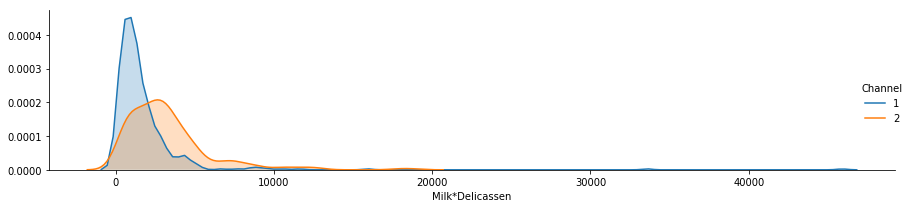

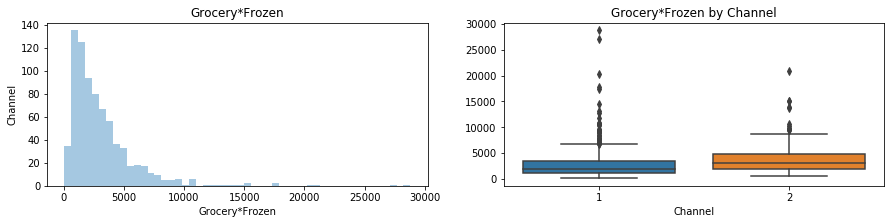

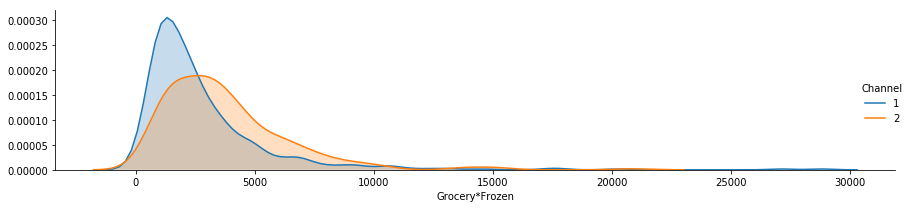

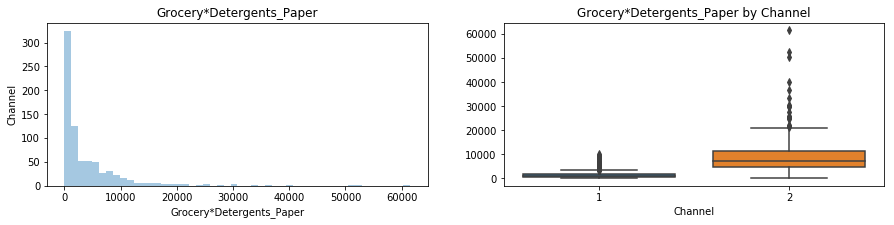

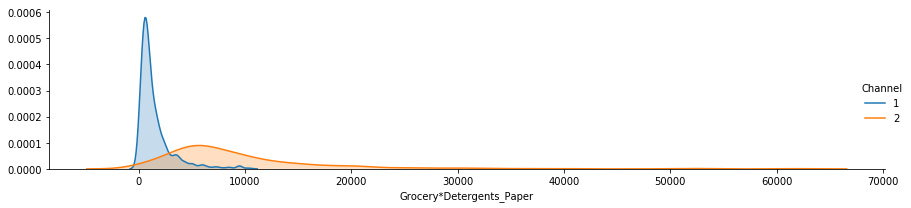

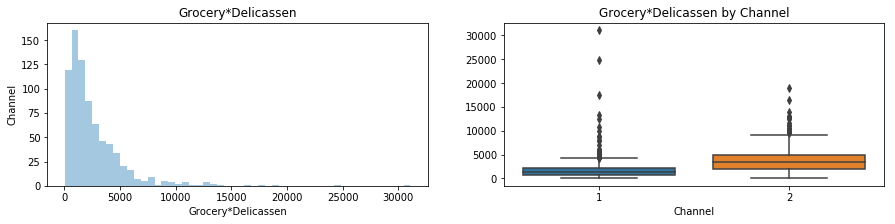

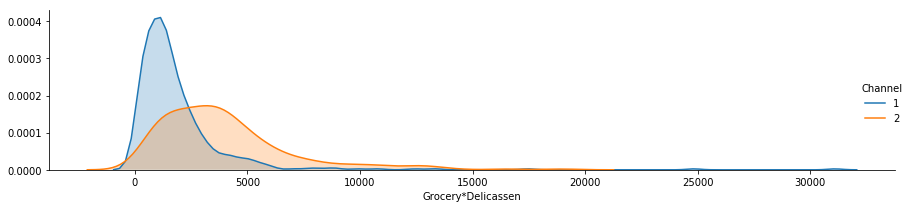

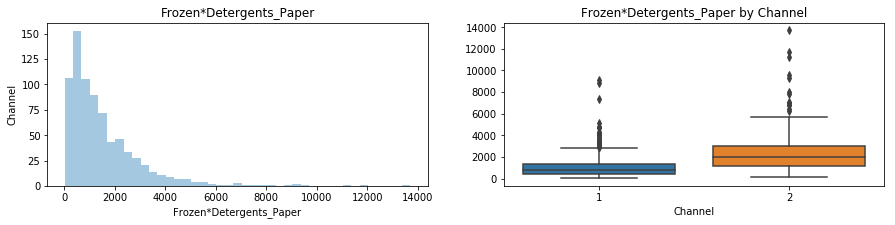

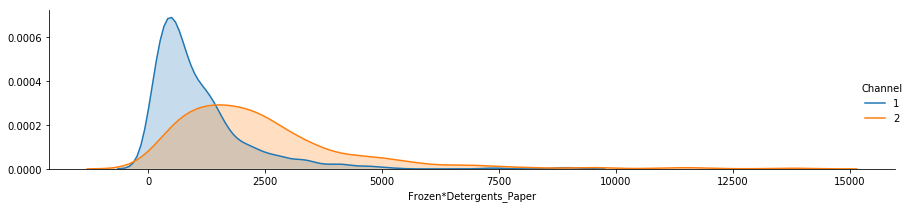

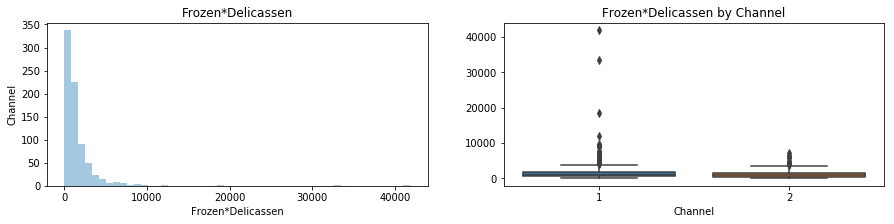

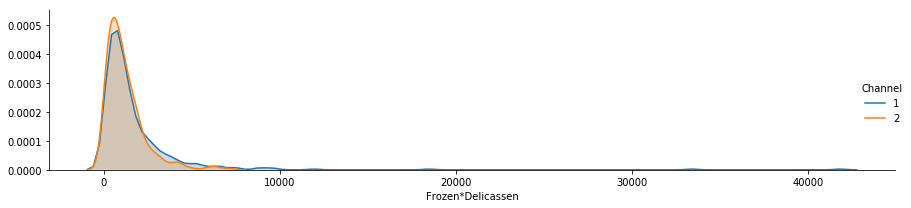

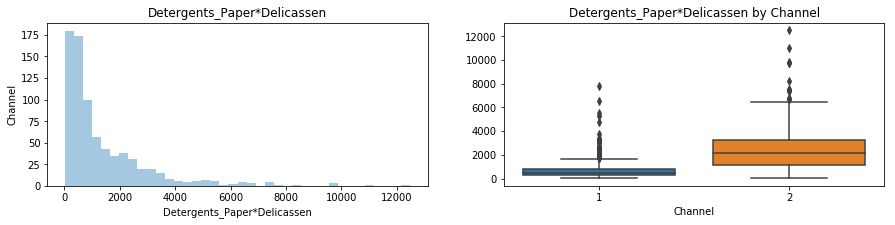

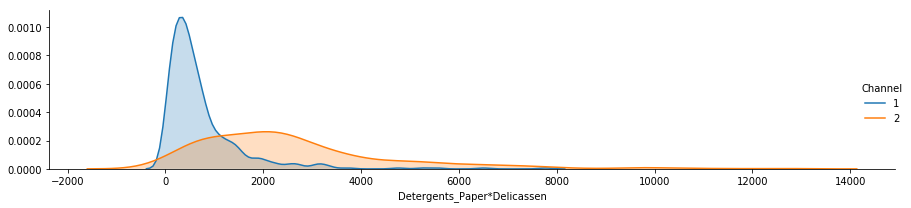

In [68]:
feature_cross = list(df2)[3:]
for feature in feature_cross:
    plot_var(df2, feature, feature, 'Channel', continuous=True)

#### - The most distinguishable interaction effects between two channels are "Milk * detergent_paper" and "Grocery * detergent_paper". 
#### - Proposed offering for channel 2 customer: discount for purchasing "milk and detergent paper" or "grocery and detergent paper".
#### - Proposed offering for channel 1 customer: discount on "fresh and frozen"
#### - Alternative offering for channel 2 customer: discount on detergent paper plus any other category. It is a broader loyalty program and offers more freedom for chanell 2 customers. 